In [1]:
import gc
import torch
import time

from pydantic import BaseModel, Field
from typing import Literal, List, Dict, Any, Tuple
from typing_extensions import TypedDict
from IPython.display import Image, display

from langchain_community.document_loaders import PyPDFLoader
from langchain_chroma import Chroma
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_classic.storage import InMemoryStore
from langchain_classic.retrievers import ContextualCompressionRetriever
from langchain_classic.retrievers.document_compressors import CrossEncoderReranker
from langchain_classic.retrievers.parent_document_retriever import ParentDocumentRetriever
from langgraph.graph import END, StateGraph

In [2]:
embeddings = HuggingFaceEmbeddings(model='BAAI/bge-m3', model_kwargs={'device':'cuda'}, encode_kwargs={'batch_size':8})
model = ChatOpenAI(model='gpt-5-mini', temperature=0)
hf_model = HuggingFaceCrossEncoder(model_name='BAAI/bge-reranker-v2-m3', model_kwargs={'device':'cuda'})

In [3]:
loader = PyPDFLoader('./data/투자설명서.pdf')
docs = loader.load()
full_text = '\n\n'.join(doc.page_content for doc in docs)

In [4]:
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=300)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=60)
vectorstore = Chroma(collection_name='split_parents_self_rag', embedding_function=embeddings)
docstore = InMemoryStore()

In [5]:
retriever = ParentDocumentRetriever(
    docstore=docstore,
    vectorstore=vectorstore,
    parent_splitter=parent_splitter,
    child_splitter=child_splitter
)

docs = retriever.add_documents([Document(page_content=full_text)])

In [6]:
print(vectorstore._collection.count())
print(len(list(docstore.yield_keys())))

1323
264


In [7]:
reranker = CrossEncoderReranker(model=hf_model, top_n=5)

compression_retriever = ContextualCompressionRetriever(
    base_compressor=reranker,
    base_retriever=retriever
)

In [8]:
class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[Document]
    retry_count: int

In [9]:
def retrieve(state):
    print('--- retrieve ---')

    question = state['question']
    documents = compression_retriever.invoke(question)

    return {'documents':documents, 'question':question, 'retry_count':0}

In [10]:
def grade_documents(state):
    print('--- check relevance ---')

    question = state['question']
    documents = state['documents']

    class Grade(BaseModel):
        binary_score: str = Field(description='문서와 질문이 관련이 있으면 "yes", 아니면 "no"')
    
    structured_llm_grader = model.with_structured_output(Grade)

    system = '''당신은 제공된 연관 문서가 주어진 질문과 관련이 있는지, 그리고 질문에 답하는 데 유용한 정보를 제공하는지 판단하는 것입니다.
    철저하게 검증하여 문서가 질문의 키워드나 의미를 포함하고 있다면 "yes"를, 아니라면 "no"를 출력하세요.'''
    grade_prompt = ChatPromptTemplate.from_messages(
        [('system', system),
         ('human', '질문: {question}\n문서: {documents}')]
    )
    retrieval_grader = grade_prompt | structured_llm_grader

    filtered_docs = []
    for doc in documents:
        score = retrieval_grader.invoke({'question':question, 'documents':doc.page_content})
        if score.binary_score == 'yes':
            print(f' -- 문서 채택')
            filtered_docs.append(doc)
        else:
            print(f' -- 문서 기각')
    
    return {'documents':filtered_docs, 'question':question}

In [11]:
def transform_query(state):
    print('--- transform query ---')

    question = state['question']
    documents = state['documents']
    retry_count = state.get('retry_count', 0) + 1

    system = '''당신은 사용자의 질문을 검색에 더 최적화된 형태로 다듬는 전문가입니다.
    원래 질문의 의도를 유지하면서, 더 좋은 문서를 찾을 수 있도록 질문을 수정하세요.'''
    retry_prompt = ChatPromptTemplate.from_messages(
        [('system', system),
         ('human', '원본 질문: {question}')]
    )
    question_rewriter = retry_prompt | model | StrOutputParser()

    better_question = question_rewriter.invoke({'question':question})
    print(f' -- 수정된 질문: {better_question}')

    return {'documents':documents, 'question':better_question, 'retry_count':retry_count}

In [12]:
def generate(state):
    print('--- generate ---')

    question = state['question']
    documents = state['documents']

    context = '\n\n'.join(doc.page_content for doc in documents)
    prompt = ChatPromptTemplate.from_template(
        '''다음 문서들을 바탕으로 질문에 답변하세요.
        문서: {context}
        질문: {question}
        답변:'''
    )
    rag_chain = prompt | model | StrOutputParser()

    generation = rag_chain.invoke({'context':context, 'question':question})

    return {'documents':documents, 'question':question, 'generation':generation}

In [13]:
def decide_to_generate(state):
    filtered_documents = state['documents']
    retry_count = state.get('retry_count', 0)

    if not filtered_documents:
        if retry_count > 3:
            print('--- decision: dax retried reached -> END ---')
            return 'generate'
        print('--- decision: no relevant docs -> transform query ---')
        return 'transform_query'
    else:
        print('--- decision: docs found -> generate ---')
        return 'generate'

In [14]:
workflow = StateGraph(GraphState)

workflow.add_node('retrieve', retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('transform_query', transform_query)
workflow.add_node('generate', generate)

workflow.set_entry_point('retrieve')

workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {'transform_query':'transform_query', 'generate':'generate'}
)
workflow.add_edge('transform_query', 'retrieve')
workflow.add_edge('generate', END)

app = workflow.compile()

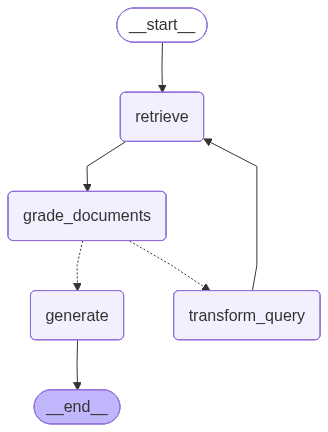

--- retrieve ---
--- check relevance ---
 -- 문서 채택
 -- 문서 채택
 -- 문서 기각
--- decision: docs found -> generate ---
--- generate ---

--- 최종 답변 ---
요약하면 당사가 공시한 주요 라이선스아웃 수익은 다음과 같습니다.

1) (주)LG화학 — BVAC‑Neo(개인맞춤형 Neo‑Antigen 암백신)
- 총 계약금액: 183,500 백만원 (단위: 백만원) = 183,500,000,000원 (약 183.5억 원 × 10 → 183.5억원? 주의: 표시는 ‘백만원’ 단위로, 183,500백만원 = 183,500,000,000원 = 183.5억×10? — 명확히는 183,500 백만원 = 183.5 billion KRW)
- 수취(Upfront): 1,000 백만원 = 1,000,000,000원 (1,000백만원, 2021.06.25 수령)
- 마일스톤: 182,500 백만원(개발·허가·판매 단계별 수취 조건)
- 로열티: 순매출에 따라 별도 지급(판매 발생 시 수령)
- 수취금액 중 계약금(1,000백만원)은 반환의무 없음. 현재 개발단계: 비임상(공동개발위원회 가동, 기술자료 제공·생산기술이전 준비 중)

2) NeoImmuneTech (미국) — BVAC‑C 관련 기술·특허(미국 독점 전용실시권)
- 총 계약금액(계약상 표기): $567,000
- 수취(Upfront): $567,000 (반환의무 없음)
- 로열티 및 재실시권 수익분배: 별도(계약 조건에 따름)
- 대상지역: 미국, 진행단계: 비임상

참고(리스크)
- 마일스톤·로열티는 향후 개발·임상·허가·상업화 성과에 따라 실현되며 실패·지연 시 수취액 감소 가능
- 계약 초기 수령한 계약금은 반환의무가 없는 것으로 공시됨

원하시면 금액을 원/달러로 환율 적용해 재계산하거나, 재무제표상 인식액(회계장부상의 수취액·공정가치 변동 등)도 정리해 드리겠습니다.


In [15]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    pass

question = '이 회사의 바이오 의약품 라이센스 아웃 수익을 알려줘.'
inputs = {'question':question}
for output in app.stream(inputs):
    pass

print('\n--- 최종 답변 ---')
print(output['generate']['generation'])